# Notebook for pre-processing the events to create jet images

Series of functions

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import math as m
import os
import numpy as np
from progressbar import ProgressBar, Percentage, Bar
import faulthandler
faulthandler.enable()
from copy import copy
from skimage import transform
import dask.array as da
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

2023-09-07 15:34:42.419175: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Splitting each event and storing them into a dataframe

In [2]:
def event_split_subjet(filename): 
    """
    Input: Jet constituent csv file from delphes macro
    Output: List containing indices of each event
    More efficient to only read in a single event into a dataframe at a time.
    """
    file = open(filename).read().splitlines() 
    lines = [0]
    for i in range(len(file)):
        if file[i] == '0,0,0,0,0,0,0,0,0,0,0':
            lines.append(i)
    return lines

In [3]:
def event_split_leadingjet(filename): 
    """
    Input: Jet constituent csv file from delphes macro
    Output: List containing indices of each event
    More efficient to only read in a single event into a dataframe at a time.
    """
    file = open(filename).read().splitlines() 
    lines = [0]
    for i in range(len(file)):
        if file[i] == '0,0,0,0,0,0':
            lines.append(i)
    return lines

In [4]:
def read_data_event_subjet(filename, event_num, event_lines):
    """
    Read event from csv file, using event_split output to find specific event.
    Return dataframe containing all particles in event, split into each jet they belong to
    """
    cols = ['subjet_num', 'subjet_pt', 'subjet_m', 'subjet_eta', 'subjet_phi', 'part_num', 
            'part_pdg', 'part_pt', 'part_m', 'part_eta', 'part_phi']
    # event_lines is list output from event_split
    # read between nth event start line and n+1th event start line to read desired (nth) event only
    event_start = event_lines[event_num-1]
    event_end = event_lines[event_num]
    nrows = event_end-event_start
    # read event into pandas dataframe
    df = pd.read_csv(filename,names=cols,skiprows=event_start,nrows=nrows)
    # add event_count column, remove event split 0 rows and define ordered dataframe columns
    df['event_count'] = event_num
    #df = df.drop(df[(df.part_pdg == 2)].index)
    #df.reset_index(drop=True, inplace=True)
    df = df[['event_count', 'subjet_num', 'subjet_pt', 'subjet_m', 'subjet_eta', 'subjet_phi', 'part_num', 
             'part_pdg','part_pt', 'part_m', 'part_eta', 'part_phi']]
    return df

In [5]:
def read_data_event_leadingjet(filename, event_num, event_lines):
    """
    Read event from csv file, using event_split output to find specific event.
    Return dataframe containing all particles in event, split into each jet they belong to
    """
    cols = [ 'leadjet_const_num', 'leadjet_const_pdg', 'leadjet_const_pt', 'leadjet_const_m', 
            'leadjet_const_eta', 'leadjet_const_phi']
    # event_lines is list output from event_split
    # read between nth event start line and n+1th event start line to read desired (nth) event only
    event_start = event_lines[event_num-1]
    event_end = event_lines[event_num]
    nrows = event_end-event_start
    # read event into pandas dataframe
    df = pd.read_csv(filename,names=cols,skiprows=event_start,nrows=nrows)
    # add event_count column, remove event split 0 rows and define ordered dataframe columns
    df['event_count'] = event_num
    df = df.drop(df[(df.leadjet_const_pdg == 1)].index)
    #df = df.drop(df[(df.leadjet_const_pdg == -1)].index)
    df.reset_index(drop=True, inplace=True)
    df = df[['event_count', 'leadjet_const_num', 'leadjet_const_pdg', 'leadjet_const_pt', 'leadjet_const_m', 
            'leadjet_const_eta', 'leadjet_const_phi']]
    return df

# Pre-processing Steps

1.Translation: Translate all leading jet/ trimmed jet constituents in η − φ space to put the leading subjet at the origin.

In [6]:
def translate_jet(df_leadjet,df_subjet):
    """Translate constituents of leading jet and putting leading subjet at (eta, phi) = (0, 0).
    """
    # Translate constituents of jet
    df_leadjet['leadjet_const_eta'] -= df_subjet['subjet_eta'][0]
    df_leadjet['leadjet_const_phi'] -= df_subjet['subjet_phi'][0]
    # checking whether constituent phi is in [-pi, pi] range
    df_leadjet['leadjet_const_phi'] = np.mod(df_leadjet['leadjet_const_phi'] + np.pi, 2*np.pi) - np.pi
    # Translate sub-jets
    df_subjet['subjet_eta'] -= df_subjet['subjet_eta'][0]
    df_subjet['subjet_phi'] -= df_subjet['subjet_phi'][0]
    # again checking whether subjet phi is in [-pi, pi] range
    df_subjet['subjet_phi'] = np.mod(df_subjet['subjet_phi'] + np.pi, 2*np.pi) - np.pi

2. Get edges to contain all subjets and histograms of pt deposits

In [7]:
def pixel_edges(leadingjet_size, pixel_grid, border):
    """Return pixel edges required to contain all the subjets.

    border is interpreted as a fraction of the leaingjet_size
    """
    image_edge = (1. + border) * leadingjet_size
    return (np.arange(-image_edge, image_edge+pixel_grid[0], pixel_grid[0]),
            np.arange(-image_edge, image_edge+pixel_grid[1], pixel_grid[1]))

In [8]:
def pixel(df_leadjet, edges):
    """Return eta-phi histogram of transverse energy deposits.

    Optionally set all instensities below cutoff to zero.
    """
    jet_image, _, _ = np.histogram2d(df_leadjet['leadjet_const_eta'], df_leadjet['leadjet_const_phi'],
                                 bins=(edges[0], edges[1]),weights=df_leadjet['leadjet_const_pt'])
    return jet_image

3. Rotation: Rotate the jet image to put the sub-leading subjet directly below the leading subjet. If no subjets are present for rotation, align the principle component of the jet image along the vertical axis.

In [9]:
def rotate_jet_image(jet_image, df):
    """Return rotated and repixelised image array.
    Rotation puts subleading subjet or first principle component at -pi/2.
    """
    # Use sub-leading subject information to rotate
    if len(df['subjet_num']) > 1:
        theta = np.arctan2(df['subjet_phi'][1], df['subjet_eta'][1])
        theta = -90.0-(theta*180.0/np.pi)
        return transform.rotate(jet_image, theta, order=3)
          
    # Use principle component of image intensity to rotate
    width, height = jet_image.shape
    pix_coords = np.array([[i, j] for i in range(-width+1, width, 2)
                           for j in range(-height+1, height, 2)])
    covX = np.cov(pix_coords, aweights=np.reshape(jet_image, (width*height)),
                  rowvar=0, bias=1)
    e_vals, e_vecs = np.linalg.eigh(covX)
    pc = e_vecs[:,-1]
    theta = np.arctan2(pc[1], pc[0])
    theta = -90.0-(theta*180.0/np.pi)
    image = transform.rotate(jet_image, theta, order=3)
    # Check orientation of principle component
    pix_bot = np.sum(image[:, :-(-height//2)])
    pix_top = np.sum(image[:, (height//2):])
    if pix_top > pix_bot:
        image = transform.rotate(image, 180.0, order=3)
        theta += 180.0

    
    return image

4. Reflect the jet image in the horizontal direction to put the third-leading subjet on the righthand side. If there are only two subjets reflect to ensure that the summed image intensity is highest on the right-hand side.

In [10]:
def reflect_image(image, df):
    """Return reflected image array.

    Reflection puts subsubleading subjet or highest intensity on right side.
    """
    width, height = image.shape
    if len(df['subjet_num']) > 2:
        # Use subsubleading subjet information to find parity
        theta = np.arctan2(df['subjet_phi'][2], df['subjet_eta'][2])
        theta = -(np.pi/2)-theta
        parity = np.sign(np.cos(-theta)*df['subjet_eta'][2] +
                         np.sin(-theta)*df['subjet_phi'][2])
    else:
        # Use intensity to find parity
        pix_l = np.sum(image[:-(-width//2)].flatten())
        pix_r = np.sum(image[(width//2):].flatten())
        parity = np.sign(pix_r - pix_l)

    if parity >= 0:
        return image
    t_image = np.array(image)
    for i in range(width):
        t_image[i] = image[-i-1]
    return t_image

5. Crop the jet image at 25×25 pixels and normalise pixel intensities to make the sum of their squares equal to one.

In [11]:
def crop_normalise(image, out_width):
    """Return rescaled and cropped image.
    """
    width, height = image.shape
    out_height = int(np.rint(float(out_width * height) / width))
    t_width = int(np.rint(out_width))
    t_height = int(np.rint(out_height))
    # crop
    final_image= image[int((t_width - out_width) / 2):int((t_width + out_width) / 2), 
                       int((t_height - out_height) / 2):int((t_height + out_height) / 2)]
    return final_image / np.sum(final_image**2)


In [12]:
def preprocess(df_subjet, df_leadjet, rotate,reflect,out_width,normalize):
    translate_jet(df_leadjet, df_subjet)
    edges = pixel_edges(leadingjet_size=1.2, pixel_grid=(0.1, 0.1), border=0)
    image = pixel(df_leadjet, edges)
    if rotate:
        image = rotate_jet_image(image,df_subjet)
    if reflect:
        image = reflect_image(image, df_subjet)
    if normalize:
        image = crop_normalise(image,out_width)
    return image

In [23]:
def csv_plot_images(lead_in,subjet_in, n_events,output,npz_out):
    # create the output file
    image_size = 24
    h5_output = h5py.File(output, 'w')
    dset_images = h5_output.create_dataset('images',(n_events, image_size, image_size), dtype=np.double)
    # create object to contain all jet images
    jet_images = []
    event_lines_lead = event_split_leadingjet(lead_in)
    event_lines_subjet = event_split_subjet(subjet_in)
    pbar = ProgressBar()
    # loop over number of events (defined in function input)
    for i in pbar(range(1,n_events)):
        df_leadjet = read_data_event_leadingjet(lead_in, i, event_lines_lead)
        if df_leadjet.empty == False:
            df_sub = read_data_event_subjet(subjet_in, i, event_lines_subjet)
            df_subjet = df_sub[['event_count', 'subjet_num', 'subjet_pt', 'subjet_m', 'subjet_eta', 'subjet_phi']].copy()
            df_subjet = df_subjet.drop_duplicates(ignore_index=True)
            images = preprocess(df_subjet, df_leadjet,rotate=True,reflect=True,out_width=25,normalize=True)
            dset_images[i] = images
            jet_images.append(images) 
    h5_output.close()
    np.savez_compressed(npz_out, jet_images)
    return jet_images

In [25]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
#np.seterr(divide='ignore', invalid='ignore')
lead_in = "delphesfatjet_ma5_signal_doublebtag_leadingbjet_new_constituent_withisr_mpi_r12_100k_info.csv"
subjet_in ="delphesfatjet_ma5_signal_doublebtag_subjet04_new_constituents_withisr_mpi_r12_100k_info.csv"
output ="new_signal_doubleb_neutral_fixedr_10k.h5"
jet_double_btag = csv_plot_images(lead_in,subjet_in, 10000,output,"signal_10kevents_neutral_fixedr")


100% |#########################################################################|


In [26]:
def plot_jet_image(image,mode, vmin=1e-7, vmax=1e-2):
    """Display jet image.
        #vmin=1e-9, vmax=1e-2 for event based images
        #vmin=1e-6, vmax=300 or vmin=1e-6, vmax=1e-2 for average images
    Args:
        ax: matplotlib axes to plot on.
        image: array representing image to plot.
        vmin, vmax: min, max intensity values to plot.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = plt.cm.jet
    norm=mpl.colors.LogNorm(vmin, vmax)
    im = ax.imshow(image.T, extent=(-(2.5), 2.5, -(2.5), 2.5),origin='lower', norm=norm, cmap=cmap) 
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label('Normalised pT', rotation=270, labelpad=10)
    plt.xlabel(r"$\eta$")
    plt.ylabel(r"$\phi$")
    plt.title("Average "+ mode +" image")
    plt.show()

In [27]:
#read h5py file and plot event and average jet images
data_signal = h5py.File('new_signal_doubleb_neutral_fixedr_10k.h5', 'r')
#data_bbbb = h5py.File('new_bbbb_doubleb_fixedr_10k.h5', 'r')
#data_ttbar = h5py.File('new_ttbar_doubleb_fixedr_10k.h5', 'r')
#data_zbb = h5py.File('new_zbb_doubleb_fixedr_10k.h5', 'r')
jet_images_sig = data_signal['images']
#jet_images_bbbb = data_bbbb['images']
#jet_images_ttbar = data_ttbar['images']
#jet_images_zbb = data_zbb['images']
avg_image_sig = np.mean(jet_images_sig,axis=0)
#avg_image_bbbb = np.mean(jet_images_bbbb,axis=0)
#avg_image_ttbar = np.mean(jet_images_ttbar,axis=0)
#avg_image_zbb = np.mean(jet_images_zbb,axis=0)
avg_image_sig

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan

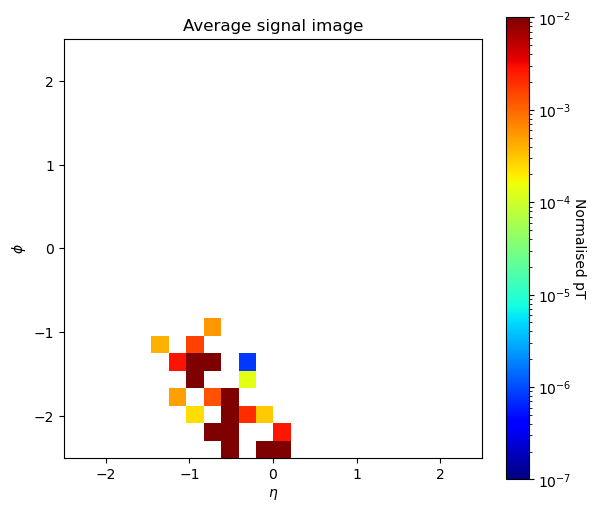

In [29]:

plot_jet_image(jet_images_sig[7000],mode ='signal')

#plot_jet_image(avg_image_signal_var,mode ='bbbb')

#plot_jet_image(avg_image_ttbar,mode ='ttbar')

#plot_jet_image(avg_image_zbb,mode ='zbb')


In [31]:
signal_jet_images = np.load('signal_10500events_varr.npz')['arr_0']
fourb_jet_images = np.load('bbbb_3500events_varr.npz')['arr_0']
zbb_jet_images = np.load('zbb_3500events_varr.npz')['arr_0']
ttbar_jet_images = np.load('ttbar_3500events_varr.npz')['arr_0']

signal_jet_images.shape[0]

10499

In [32]:
tot_jets = signal_jet_images.shape[0]+fourb_jet_images.shape[0]+zbb_jet_images.shape[0]+ttbar_jet_images.shape[0]

X = np.concatenate([signal_jet_images, fourb_jet_images, zbb_jet_images, ttbar_jet_images])
y = np.array([1]*len(signal_jet_images)+[0]*len(fourb_jet_images)+[0]*len(zbb_jet_images)+[0]*len(ttbar_jet_images))

# normalise pts to 1
X = X/X.max()

X.shape

(20996, 24, 24)

In [33]:
def create_model_cnn(X, y):
    X = X.reshape(tot_jets,24,24,1)
    #X = Input(shape=(X.shape[1:]))
    y = keras.utils.to_categorical(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model_cnn = Sequential()
    model_cnn.add(Conv2D(32, (3, 3), input_shape=(24, 24, 1), activation='relu'))
    model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.5))

    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu'))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Dense(2, activation='softmax'))
    

    model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model_cnn.fit(X_train, y_train, epochs=20, batch_size=32, shuffle=True, validation_split=0.3)

    plt.plot(history.history['accuracy'],color='b',label='Accuracy')
    plt.plot(history.history['val_accuracy'],color='b',ls='--',label='Val Acc')
    plt.plot(history.history['loss'],color='r',label='Loss')
    plt.plot(history.history['val_loss'],color='r',ls='--',label='Val Loss')
    plt.legend(loc='best')
    plt.title('Model Accuracy')
    #plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    plt.close()

    y_pred = model_cnn.predict(X_test)

    # Plot model output for signal/background (0-1)
    all_y = np.concatenate((y_pred, y_test),axis=1)
    y_pred_sig = all_y[all_y[:,3]==1.,:]
    y_pred_back = all_y[all_y[:,3]==0.,:]
    y_pred_sig = y_pred_sig[:,1]
    y_pred_back = y_pred_back[:,1]


    #x = np.linspace(0, 1, 20)
    plt.hist(y_pred_sig,bins=20,color='r',alpha=0.5,range=(0,1),label=r'Signal')
    plt.hist(y_pred_back,bins=20,color='b',alpha=0.5,range=(0,1),label=r'Backgrounds')
    #plt.hist(list(y_pred_sig),bins=20, range=(0,1), color='r', label=r'Signal', where='mid')
    #plt.hist(list(y_pred_back),bins=20, range=(0,1), color='b', label=r'Background', where='mid')
    plt.legend(loc='best', title="CNN Output Score")
    plt.show()


    fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())

    plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc(fpr, tpr)),color='b')
    plt.plot([0, 1], [0, 1], ls='--', color='g', label='Random Classification')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    plt.close()

    # TODO: fix shape of y_test/y_pred so they are lists of [0,1] values
    #print("F1-Score: ", f1_score(y_test, y_pred))

    return True

In [ ]:
#20epochs
create_model_cnn(X,y)

Epoch 1/20
322/322 [==============================] - 9s 26ms/step - loss: 0.6444 - accuracy: 0.6394 - val_loss: 0.6307 - val_accuracy: 0.6485
Epoch 2/20
322/322 [==============================] - 9s 27ms/step - loss: 0.6091 - accuracy: 0.6826 - val_loss: 0.5853 - val_accuracy: 0.7007
Epoch 3/20
322/322 [==============================] - 9s 27ms/step - loss: 0.5897 - accuracy: 0.6979 - val_loss: 0.5881 - val_accuracy: 0.7086
Epoch 4/20
322/322 [==============================] - 8s 26ms/step - loss: 0.5837 - accuracy: 0.7007 - val_loss: 0.5762 - val_accuracy: 0.7000
Epoch 5/20
322/322 [==============================] - 9s 27ms/step - loss: 0.5710 - accuracy: 0.7144 - val_loss: 0.5583 - val_accuracy: 0.7138
Epoch 6/20
322/322 [==============================] - 8s 25ms/step - loss: 0.5630 - accuracy: 0.7140 - val_loss: 0.5484 - val_accuracy: 0.7231
Epoch 7/20
322/322 [==============================] - 9s 28ms/step - loss: 0.5553 - accuracy: 0.7192 - val_loss: 0.5503 - val_accuracy: 0.7388